## Importing Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras import optimizers
from keras.layers import Dropout

## Exploring Data

In [4]:
quandl.ApiConfig.api_key = '_gxgHgs8VTSV7VEAhTx2#12131'

In [5]:
gold_price = pd.DataFrame()

In [6]:
data = quandl.get("LBMA/GOLD", collapse='annual')

In [7]:
gold_price['Date'] = list(map(lambda x: x.year, data.index))

In [8]:
gold_price['Price'] = data['USD (AM)'].values

In [9]:
data_all = quandl.get("LBMA/GOLD")

In [10]:
data_all['Date'] = data_all.index

In [11]:
df = data_all.groupby(data_all['Date'].dt.year)['USD (AM)'].agg(['median', 'mean', 'max'])

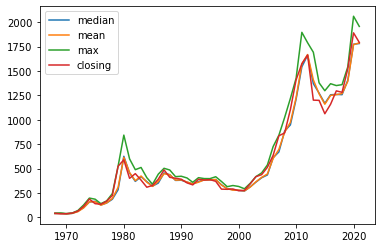

In [12]:
plt.plot(df.index,df['median'].values, label = 'median')
plt.plot(df.index,df['mean'].values, label = 'mean')
plt.plot(df.index,df['max'].values, label = 'max')
plt.plot(gold_price['Date'], gold_price['Price'], label = 'closing')
plt.legend();

In [13]:
data1 = quandl.get("LBMA/GOLD", collapse='daily')

In [14]:
data1['Date'] = data1.index

In [15]:
data1['USD (AM)'] = data1['USD (AM)'].fillna(43.05)

## Data Preprocessing 

In [16]:
prices = data1['USD (AM)'].values

In [17]:
scaler=MinMaxScaler(feature_range=(0,1))
fitted_prices=scaler.fit_transform(np.array(prices).reshape(-1,1))

In [18]:
split_point=int(len(fitted_prices)*0.65)
test_size=len(fitted_prices)-split_point
train_data,test_data=fitted_prices[0:split_point,:],fitted_prices[split_point:len(fitted_prices),:1]

In [19]:
split_point,test_size

(8763, 4720)

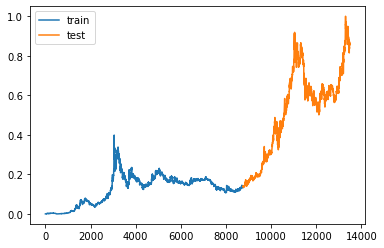

In [84]:
plt.plot(range(split_point),train_data.flatten(), label = 'train')
plt.plot(range(split_point,split_point+test_size), test_data.flatten(), label = 'test')
plt.legend();

## Feature Engineering

In [21]:
# convert an array of values into a dataset matrix
def data_make(dataset, step=1):
	X, y = [], []
	for i in range(len(dataset)-step-1):
		a = dataset[i:(i+step), 0]   
		X.append(a)
		y.append(dataset[i + step, 0])
	return np.array(X), np.array(y)

In [22]:
time_step = 100
X_train, y_train = data_make(train_data, time_step)
X_test, ytest = data_make(test_data, time_step)

In [23]:
print(X_train.shape), print(y_train.shape)

(8662, 100)
(8662,)


(None, None)

In [24]:
print(X_test.shape), print(ytest.shape)

(4619, 100)
(4619,)


(None, None)

In [25]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Model Configuration and Prediction

In [26]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
np.shape(y_train)

(8662,)

In [29]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 8662 samples, validate on 4619 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
8662/8662 [==============================] - 26s 3ms/sample - loss: 8.4710e-04 - val_loss: 0.0013
Epoch 2/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 4.3046e-05 - val_loss: 0.0021
Epoch 3/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 4.2558e-05 - val_loss: 0.0020
Epoch 4/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 3.8632e-05 - val_loss: 0.0011
Epoch 5/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 3.5987e-05 - val_loss: 0.0010
Epoch 6/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 3.2098e-05 - val_loss: 8.5398e-04
Epoch 7/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 2.9444e-05 - val_loss: 0.0027
Epoch 8/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 2.82

8662/8662 [==============================] - 24s 3ms/sample - loss: 8.2553e-06 - val_loss: 2.8893e-04
Epoch 70/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 9.8846e-06 - val_loss: 2.8929e-04
Epoch 71/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 7.8748e-06 - val_loss: 2.7927e-04
Epoch 72/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 9.4747e-06 - val_loss: 1.6006e-04
Epoch 73/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 8.3971e-06 - val_loss: 2.7540e-04
Epoch 74/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 8.1946e-06 - val_loss: 3.0090e-04
Epoch 75/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 8.8626e-06 - val_loss: 2.4042e-04
Epoch 76/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 7.8063e-06 - val_loss: 6.9086e-04
Epoch 77/100
8662/8662 [==============================] - 24s 3ms/sample - loss: 7.9212e-06 -

## Model Evaluation 

In [39]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [40]:
train_predict_true=scaler.inverse_transform(train_predict)
test_predict_true=scaler.inverse_transform(test_predict)

In [44]:
test_predict

array([[0.1641449 ],
       [0.16711815],
       [0.16558005],
       ...,
       [0.82760084],
       [0.8202851 ],
       [0.8331079 ]], dtype=float32)

In [118]:
train_predict

array([[0.00392006],
       [0.00396427],
       [0.0039619 ],
       ...,
       [0.13777061],
       [0.13778171],
       [0.13848053]], dtype=float32)

In [36]:
results = model.evaluate(X_test, ytest, batch_size=128)

4619/4619 [==============================] - 1s 306us/sample - loss: 2.6476e-04


In [37]:
results

0.0002647620744578392

In [38]:
from sklearn.metrics import mean_squared_error

In [92]:
mean_squared_error(y_train, train_predict, squared = False)*100

0.2917395462387904

RMSE of 0.29% is pretty good but seems like the model might be overfitted on the training dataset

In [91]:
mean_squared_error(ytest, test_predict, squared = False)*100

1.6271510830126763

RMSE of 1.6% is really good for the testing set and doesn't seem like the model overfitted.

## Checking Predictions

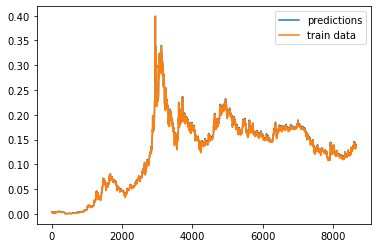

In [128]:
plt.plot(range(len(train_predict)), train_predict, label = 'predictions')
plt.plot(range(len(y_train)), y_train, label = 'train data')
plt.legend();

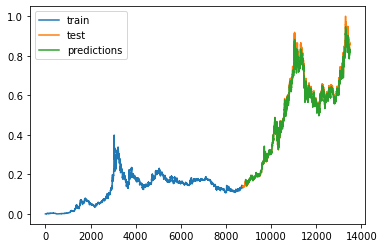

In [97]:
plt.plot(range(split_point),train_data.flatten(), label = 'train')
plt.plot(range(split_point,split_point+test_size), test_data.flatten(), label = 'test')
plt.plot(range(split_point+101,split_point+test_size), test_predict.flatten(), label = 'predictions')
plt.legend();

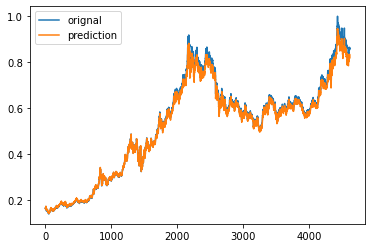

In [111]:
plt.plot(range(len(ytest)), ytest.flatten(), label = 'orignal')
plt.plot(range(len(test_predict)), test_predict.flatten(), label = 'prediction')
plt.legend();

In [119]:
y_test = ytest.reshape((len(ytest),1))
ytest_true =scaler.inverse_transform(y_test)
test_predict_true=scaler.inverse_transform(test_predict)

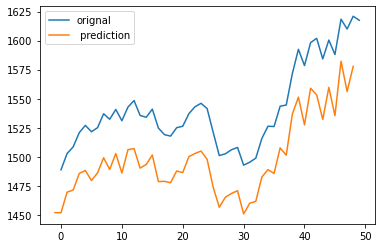

In [134]:
plt.plot(range(len(ytest_true[2100:2150])), ytest_true.flatten()[2100:2150], label = 'orignal')
plt.plot(range(-1,len(test_predict_true[2100:2150])-1), test_predict_true.flatten()[2100:2150], label = ' prediction')
plt.legend();

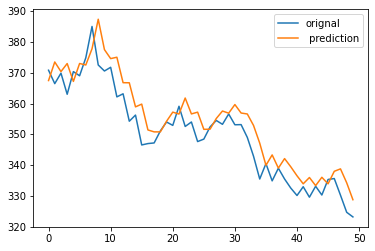

In [135]:
plt.plot(range(len(ytest_true[:50])), ytest_true.flatten()[:50], label = 'orignal')
plt.plot(range(len(test_predict_true[:50])), test_predict_true.flatten()[:50], label = ' prediction')
plt.legend();

Not going by the predicted value but the general trend, it seems like our predictions are leading the orignal values by one day

## Predicting some future values

In [259]:
def future_pred(days):    
    data = [X_test[-100]]
    predictions = []
    for i in range(days):
        print(f'Prediction for last day: {data[i][-1][0]}',end=' ')
        pred = model.predict(np.array([data[i]]))
        print(f'Prediction for day: {pred[0][0]}')
        predictions.append(pred[0][0])
        new_data = data[i][1:]
        new_data = np.append(new_data,pred,axis=0)
        data.append(new_data)
    return predictions

In [260]:
days = 5
predictions = future_pred(days)

Prediction for last day: 0.9027990901600114 Prediction for day: 0.8686381578445435
Prediction for last day: 0.8686381578445435 Prediction for day: 0.8169140219688416
Prediction for last day: 0.8169140219688416 Prediction for day: 0.769730269908905
Prediction for last day: 0.769730269908905 Prediction for day: 0.7280261516571045
Prediction for last day: 0.7280261516571045 Prediction for day: 0.694178581237793


In [261]:
true_prd = np.array(predictions).reshape((len(predictions),1))
true_prd =scaler.inverse_transform(true_prd)
train_data_true =scaler.inverse_transform(train_data)
test_data_true=scaler.inverse_transform(test_data)

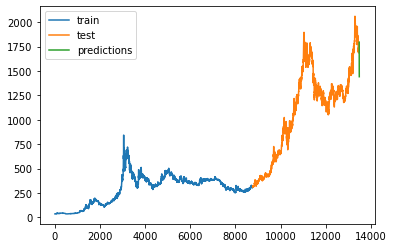

In [262]:
plt.plot(range(split_point),train_data_true.flatten(), label = 'train')
plt.plot(range(split_point,split_point+test_size), test_data_true.flatten(), label = 'test')
plt.plot(range(split_point+test_size,split_point+test_size+days), true_prd.flatten(), label = 'predictions')
plt.legend();

## Conclusion

It is not possible to predict the gold price behaviour by just using the historical price. The LSTM prediction is far from acceptable as even though the testing data prices seemed fair it can't predict well in future